In [1]:
import trafficmc

In [2]:
def therm(x, N):
    for _ in range(N):
        x.step()
    return x

In [3]:
def sim(mc, N, **fns):
    measurements = {k: [] for k in fns}
    for _ in range(N):
        mc.step()
        for k in fns:
            measurements[k].append(fns[k](mc))
    return measurements

In [4]:
mc = trafficmc.TrafficMC(1000, 120, 5, [1/3])

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

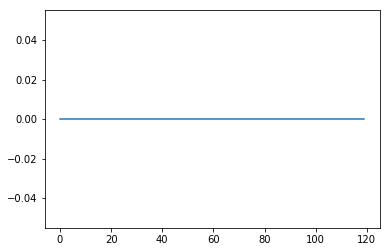

In [6]:
plt.plot(mc.v)

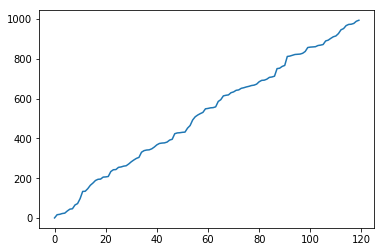

In [7]:
plt.plot(mc.x)

In [8]:
vs = []
for _ in range(100):
    vs.append(mc.v.mean())
    mc.step()

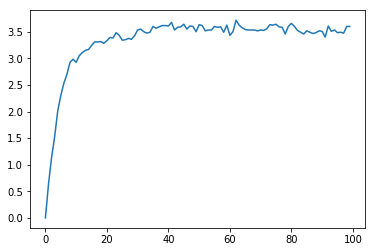

In [9]:
plt.plot(vs)

In [10]:
therm(mc, 1000)

In [11]:
results = sim(mc, 1000, x = lambda mc: mc.x.copy())

In [12]:
import numpy as np

In [13]:
def viz_sim(res, N, ax=None):
    if not ax:
        ax = plt.gca()
    im = np.zeros((len(res['x']), N))
    for i, xs in enumerate(res['x']):
        for x in xs:
            im[i, x] = 1
    plt.imshow(im, cmap='binary')
    plt.xlabel('distance on road')
    plt.ylabel('simulation time')

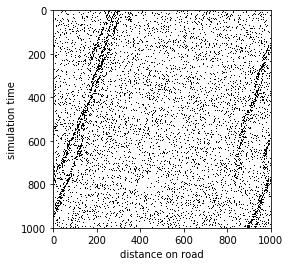

In [14]:
viz_sim(results, mc.N)

In [15]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row

In [16]:
sc = SparkContext('local[4]')

In [17]:
spark = SQLContext(sc)

# Vehicle Miles Traveled

In [18]:
mcs = (sc.parallelize([(1000, 120, 6, 1/3) for _ in range(500)])
         .map(lambda x: trafficmc.TrafficMC(*x)))

In [19]:
mcs = mcs.map(lambda x: therm(x, 1000))

In [20]:
results = (mcs.map(lambda mc: sim(mc, 1000, x = lambda mc: mc.v.sum()))
              .map(lambda res: Row(dist = float(sum(res['x'])) / 1000)))

In [21]:
df = spark.createDataFrame(results).toPandas()

In [22]:
df.head()

,dist
0,426.650
1,428.248
2,446.842
3,437.983
4,453.583


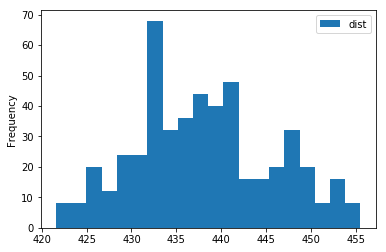

In [23]:
df.plot.hist('dist', bins = 20)

In [24]:
sc.stop()